# PFFE analysis of PER library, Seqwalk equivalent library, and random sequences

In [1]:
from Bio import SeqIO
import nupack as nu
import numpy as np
import pandas as pd
import seaborn as sns
from seqwalk import design
import matplotlib.pyplot as plt
from seqwalk import io
from tqdm import tqdm

from matplotlib import rcParams

# PER rxn conditions
# from kishi et al 2018
# 37C, 2mM magnesium
pe = nu.Model(material="dna", celsius=37, sodium=0.05, magnesium=.002)

np.random.seed(21)

In [2]:
per = io.load_library("kishi2018")
sw9 = design.max_size(9, 6, alphabet="ACT")

In [3]:
def evaluate_crosstalk(seq1, seq2, model):
    return nu.pfunc([seq1, rc(seq2)], model)[1]

def randseq(length, alphabet=4):
    if alphabet == 4:
        return "".join(np.random.choice(["A", "C", "T", "G"], length))
    return "".join(np.random.choice(["A", "C", "T"], length))

def rc(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))

In [4]:
N = 2*10**4

per_pffe = []
rand9_pffe = []
sw9_pffe = []

per_on = []
rand9_on = []
sw9_on = []


for _ in tqdm(range(N)):
    
    
    s1, s2 = np.random.choice(per, 2, replace=False)
    per_pffe.append(evaluate_crosstalk(s1,
                                       s2, pe))
    per_on.append(evaluate_crosstalk(s1,
                                       s1, pe))
    
    s1, s2 = np.random.choice(sw9, 2, replace=False)
    sw9_pffe.append(evaluate_crosstalk(s1,
                                       s2, pe))
    sw9_on.append(evaluate_crosstalk(s1,
                                       s1, pe))
    
    s1, s2 = randseq(9, alphabet=3), randseq(9, alphabet=3)
    while s1 == s2: # make sure random sequences are not the same
        s1, s2 = randseq(9, alphabet=3), randseq(9, alphabet=3)
    
    rand9_pffe.append(evaluate_crosstalk(s1,
                                       s2, pe))
    rand9_on.append(evaluate_crosstalk(s1,
                                       s1, pe))

100%|█████████████████████████████████████| 20000/20000 [03:28<00:00, 95.92it/s]


In [5]:
print("Ratios of average off-target/on-target (higher worse): ")
print("\n")

print("Kishi 18: %f" % (np.mean(np.array(per_pffe)/per_on)))
print("Random: %f" % (np.mean(np.array(rand9_pffe)/rand9_on)))
print("SW k=6: %f" % (np.mean(np.array(sw9_pffe)/sw9_on)))

Ratios of average off-target/on-target (higher worse): 


Kishi 18: 0.620622
Random: 0.600863
SW k=6: 0.603940


In [6]:
d = {
    "Library" : ["Kishi"]*2*N + ["Random"]*2*N + ["Seqwalk"]*2*N,
    "Off/On" : (["Off"]*N + ["On"]*N)*3,
    "PFFE" : per_pffe + per_on + rand9_pffe + rand9_on + sw9_pffe + sw9_on,
}

df9 = pd.DataFrame(d)

In [7]:
rcParams['figure.dpi'] = 300

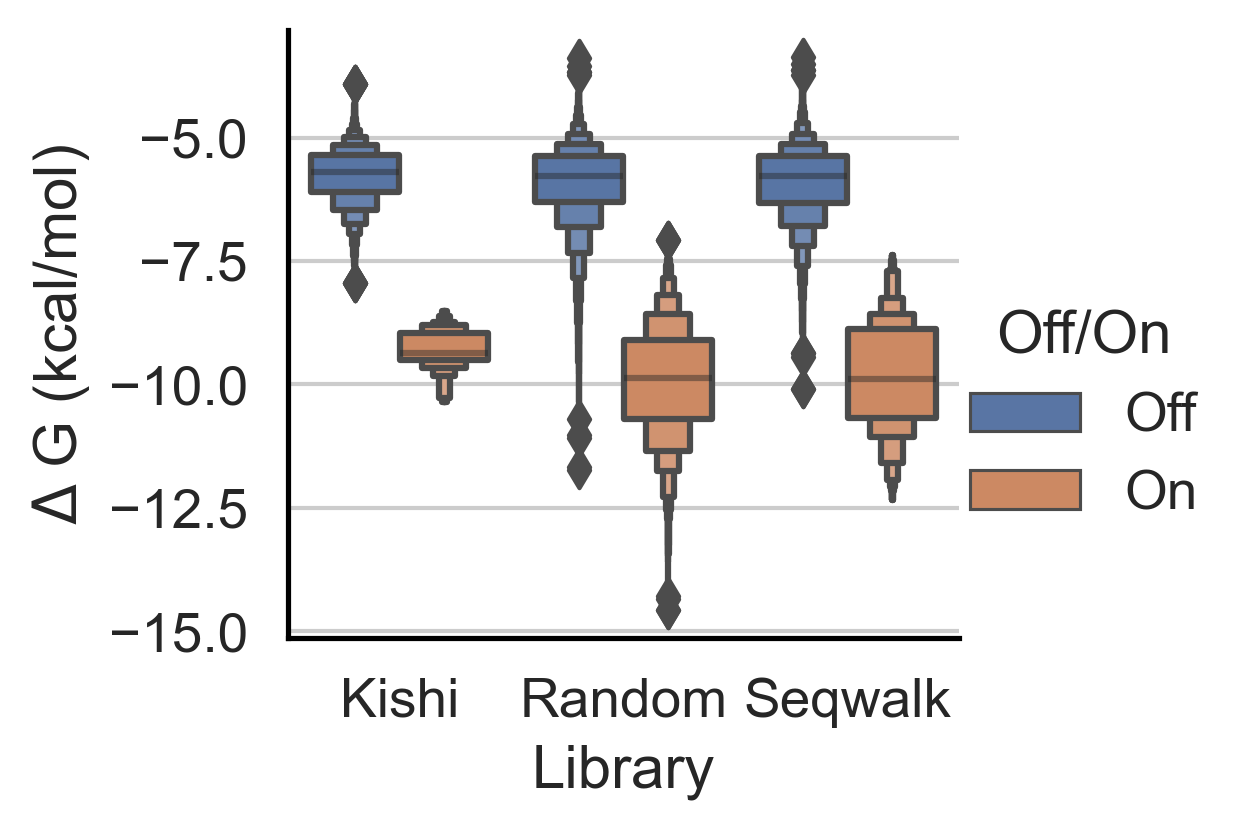

In [16]:
sns.set(font_scale=1.2, style='whitegrid')
rcParams['axes.edgecolor'] = 'black'
sns.catplot(
    data=df9, y="PFFE", x="Library", hue="Off/On",
    kind="boxen", height=3, aspect=1.2
)
plt.ylabel('$\Delta$ G (kcal/mol)')
plt.savefig("EF6_sn10.pdf", bbox_inches = 'tight')

In [17]:
PER_mixed = sum(per_pffe < np.max(per_on))/len(per_pffe)
rand_mixed = sum(rand9_pffe < np.max(rand9_on))/len(rand9_pffe)
sw_mixed = sum(sw9_pffe < np.max(sw9_on))/len(sw9_pffe)

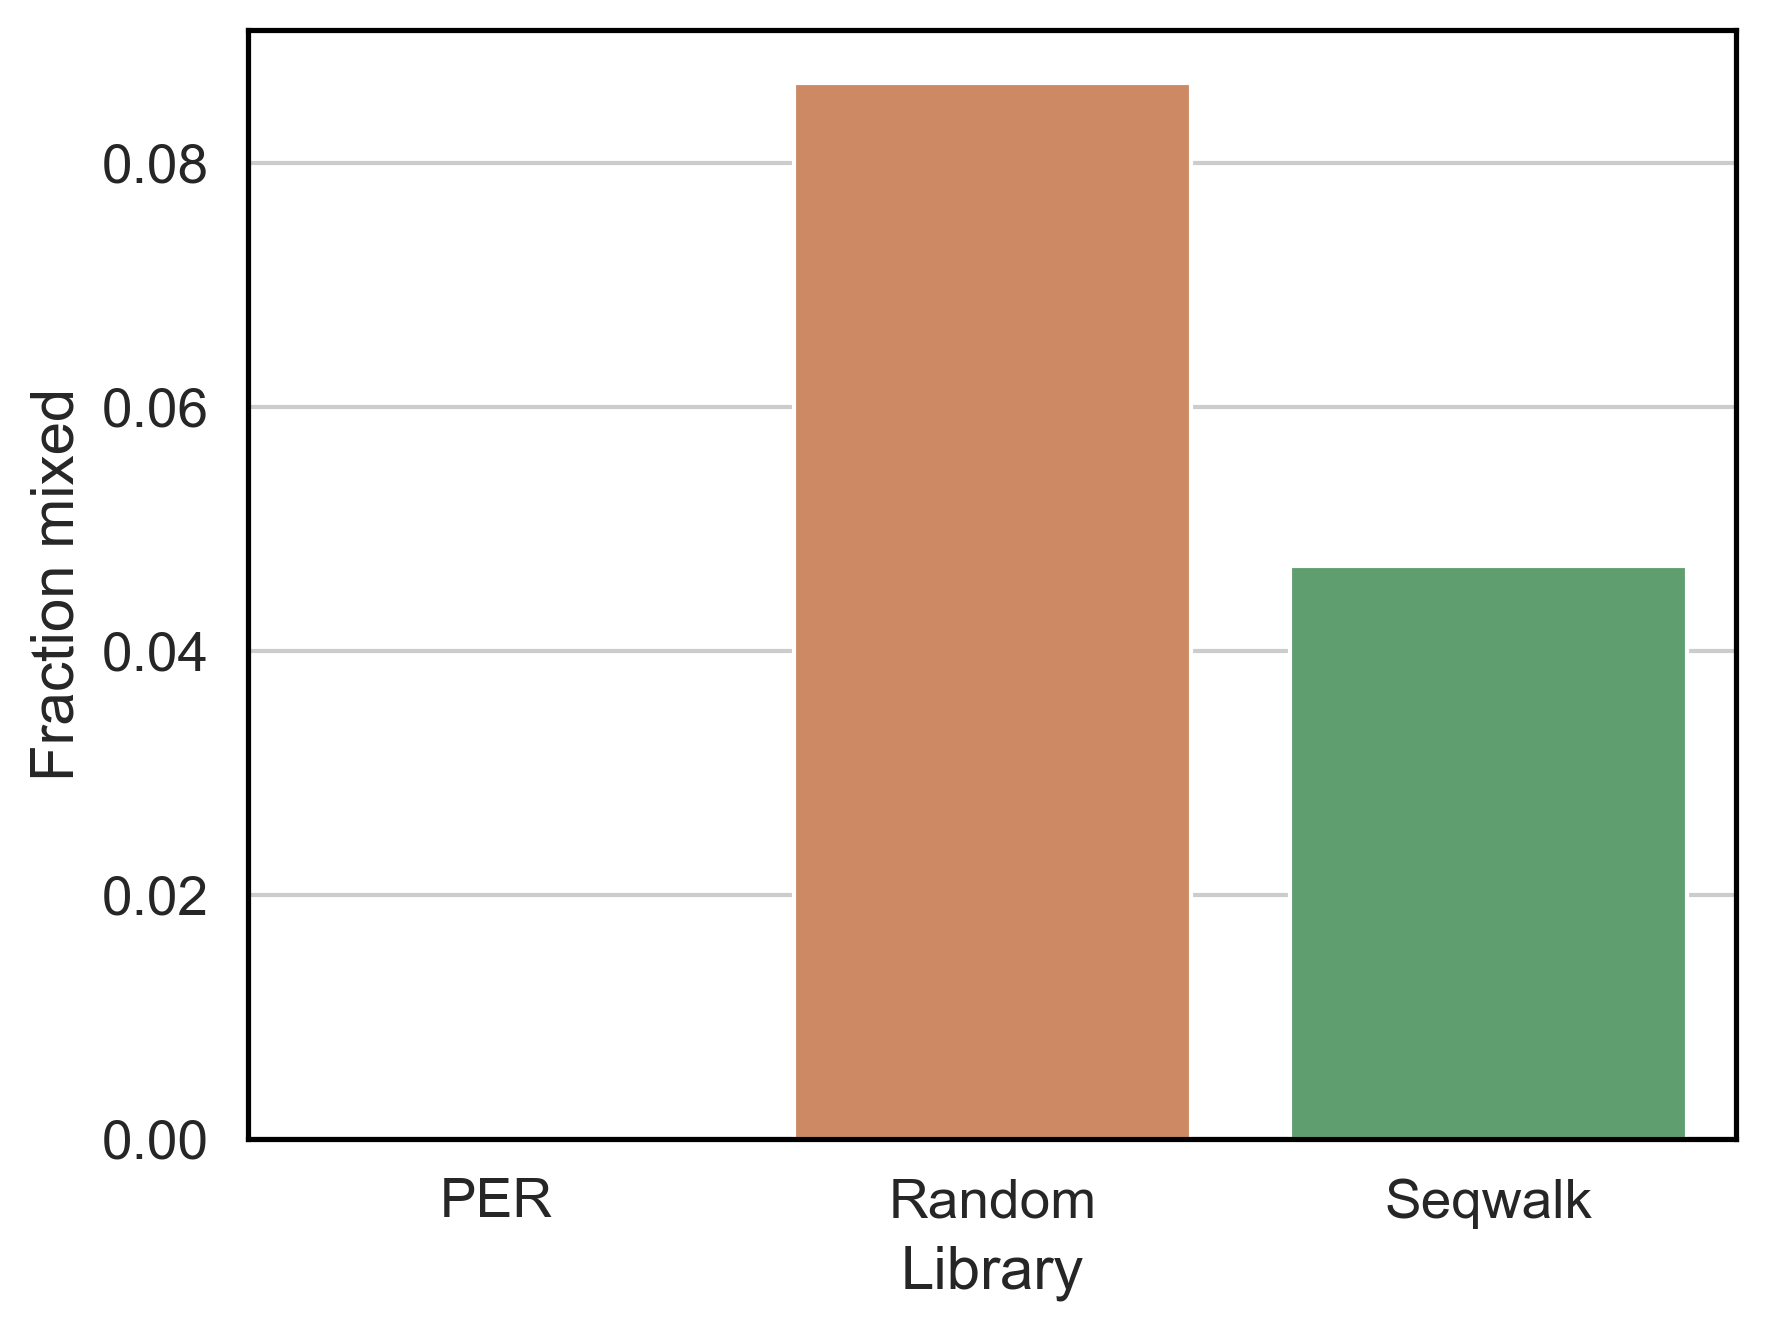

In [18]:
sns.set(font_scale=1.2, style='whitegrid')
rcParams['axes.edgecolor'] = 'black'

d ={
    "Library" : ["PER", "Random", "Seqwalk"],
    "Fraction mixed" : [PER_mixed, rand_mixed, sw_mixed]
}

sns.barplot(data=pd.DataFrame(d),
            x="Library",
            y="Fraction mixed")

plt.savefig("EF7_sn10.pdf", bbox_inches = 'tight')